# Calculate the reaction rates for the primary reactions, as well as the main secondary reactions

In [1]:

from utils import *
import numpy as np
import matplotlib.pyplot as plt

# Calculate Startup Time and Net Power Loss

Volume-averaged profile for temperature: 1.40×10¹ keV
Volume-averaged profile for density: 1.70×10²⁰ 1/m³


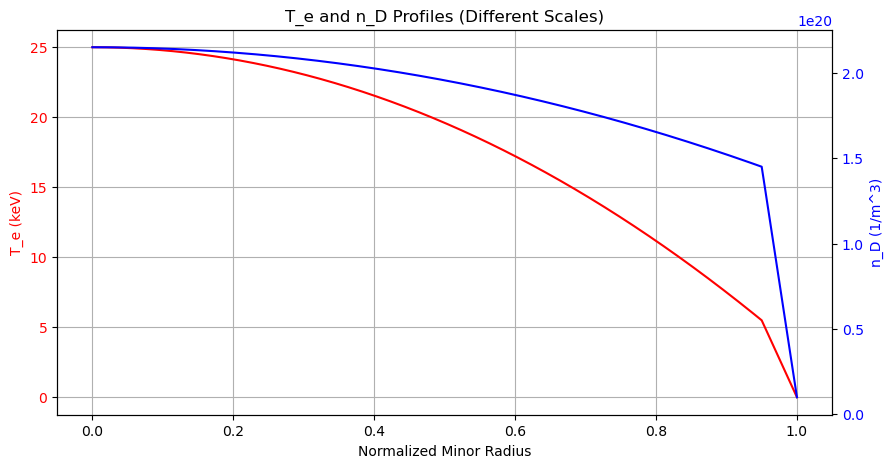

In [2]:
points = 1000  # or your desired resolution
x = np.linspace(0, 1, points)  # Normalized minor radius
# use the T_e_profile disecretized to calculate the sigmavs
T_e, T_e_avg = pedestal_profile(x, value_center=25*unit.keV, value_ped=5.5*unit.keV, value_edge=0.01*unit.keV, transition_ratio=0.95)  # [keV] is the electron temperature profile
n_D, n_D_avg = pedestal_profile(x, value_center=2.15e20*unit.m**-3, value_ped=1.45e20*unit.m**-3, value_edge=1e19*unit.m**-3, transition_ratio=0.95)  # [1/m^3] is the deuterium density profile
print(f"Volume-averaged profile for temperature: {T_e_avg:.2e~P}")
print(f"Volume-averaged profile for density: {n_D_avg:.2e~P}")
plt.figure(figsize=(10, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(x, T_e.to('keV').magnitude, label='T_e (keV)', color='red')
ax2.plot(x, n_D.to('1/m^3').magnitude, label='n_D (1/m^3)', color='blue')

ax1.set_xlabel('Normalized Minor Radius')
ax1.set_ylabel('T_e (keV)', color='red')
ax2.set_ylabel('n_D (1/m^3)', color='blue')

ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('T_e and n_D Profiles (Different Scales)')
ax1.grid()
plt.show()


In [3]:
# Input Data
V_plasma = 150 * unit.m**3  # Plasma volume [m^3]
I_ST = 3 * unit.kg  # Inventory target [kg]

# PARAMETERS FOR THE FUSION REACTION
tau_p_T = 1 * unit.s  # Tritium confinement time [s]
tau_p_He3 = 1 * unit.s # He3 confinement time [s]

# PARAMETERS FOR THE TRITIUM PRODUCTION
TBR = 1.15  # Tritium breeding ratio for DT neutrons [-]
TBR_DDn = 1  # Tritium breeding ratio for DD neutrons [-]

# PARAMETERS FOR THE NET POWER LOSS
eta_th = 0.3  # Thermal efficiency of the reactor [-]
Q = 9  # Fusion gain factor [-] Q = (Pfus-Paux)/Paux
P_aux = 100 * unit.MW  # Auxiliary heating power [MW]
Cost_per_MWh = 0.25/unit('kWh') # [USD] is the cost of electricity

In [4]:
# Calculate the reaction rates
DD_reaction_rates = calculate_reaction_rates_DD(n_D, T_e, V_plasma, tau_p_T, tau_p_He3, points)
DD_reaction_rates_avg = calculate_reaction_rates_DD(n_D_avg, T_e_avg, V_plasma, tau_p_T, tau_p_He3, points)
# Print the dictionary in the desired format with scientific notation and pretty units
print("Reaction Rates:")
for key in DD_reaction_rates:
    val = DD_reaction_rates[key]
    val_avg = DD_reaction_rates_avg.get(key, None)
    if hasattr(val, "magnitude"):
        if val_avg is not None and hasattr(val_avg, "magnitude"):
            print(f"{key}: {val:.2e~P} (using averages: {val_avg:.2e~P})")
        else:
            print(f"{key}: {val:.2e~P}")
    else:
        if val_avg is not None:
            print(f"{key}: {val:.2e} (using averages: {val_avg:.2e})")
        else:
            print(f"{key}: {val:.2e}")

Reaction Rates:
R_DDp: 3.97×10¹⁸ 1/s (using averages: 2.63×10¹⁸ 1/s)
R_DDn: 4.30×10¹⁸ 1/s (using averages: 2.79×10¹⁸ 1/s)
R_DT: 3.02×10¹⁷ 1/s (using averages: 1.04×10¹⁷ 1/s)
R_DHe3: 3.39×10¹⁵ 1/s (using averages: 4.26×10¹⁴ 1/s)
R_tot: 8.57×10¹⁸ 1/s (using averages: 5.52×10¹⁸ 1/s)
density_T: [7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.27e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.26e+16 7.25e+16 7.25e+16 7.25e+16 7.25e+16 7.25e+16 7.25e+16 7.25e+16 7.25e+16 7.25e+16 7.25e+16 7.24e+16 7.24e+16 7.24e+16 7.24e+16 7.24e+16 7.24e+16 7.24e+16 7.24e+16 7.23e+16 7.23e+16 7.23e+16 7.23e+16 7.23e+16 7.23e+16 7.23e+16 7.22e+16 7.22e+16 7.22e+16 7.22e+16 7.22e+16 7.22e+16 7.21e+16 7.21e+16 7.21e+16 7.21e+16 7.21e+16 7.20e+16 7.20e+16 7.20e+16 7.20e+16 7.20e+16 7.20e+16 7.19e+16 7.19e+16 7.19e+16 7.19e+16 7.18e+16 7.18e+16 7.18e+16 7.18e

## Estimate Tritium production

In [5]:
# calculate the tritium production rates
Tdot_DD_plasma = DD_reaction_rates["R_DDp"] # [1/s] is the rate of tritium production due to DDp fusions
Tdot_fusion = DD_reaction_rates["R_DDp"] - DD_reaction_rates["R_DT"] # [1/s] rate of tritium production due to DDp fusions, considering the losses due to DT fusions
Tdot_diff = V_plasma * DD_reaction_rates["density_T"] / tau_p_T # [1/s] is the rate of tritium production due to diffusion of tritium in the breeding blanket
Tdot_breedingDT = TBR * DD_reaction_rates["R_DT"] # [1/s] is the rate of tritium production due to DT neutrons interacting with the breeding blanket
Tdot_breedingDD = TBR_DDn * DD_reaction_rates["R_DDn"] # [1/s] is the rate of tritium production due to DD neutrons interacting with the Li6 in the breeding blanket
Tdot_tot = Tdot_fusion + Tdot_breedingDT + Tdot_breedingDD # [1/s] is the total rate of tritium production in the system

# save the values calcualted using averages
Tdot_DD_plasma_avg = DD_reaction_rates_avg["R_DDp"]  # [1/s] is the rate of tritium production due to DDp fusions
Tdot_fusion_avg = DD_reaction_rates_avg["R_DDp"] - DD_reaction_rates_avg["R_DT"]  # [1/s] rate of tritium production due to DDp fusions, considering the losses due to DT fusions
Tdot_diff_avg = V_plasma * DD_reaction_rates_avg["density_T"] / tau_p_T  # [1/s] is the rate of tritium production due to diffusion of tritium in the breeding blanket
Tdot_breedingDT_avg = TBR * DD_reaction_rates_avg["R_DT"]  # [1/s] is the rate of tritium production due to DT neutrons interacting with the breeding blanket
Tdot_breedingDD_avg = TBR_DDn * DD_reaction_rates_avg["R_DDn"]  # [1/s] is the rate of tritium production due to DD neutrons interacting with the Li6 in the breeding blanket
Tdot_tot_avg = Tdot_fusion_avg + Tdot_breedingDT_avg + Tdot_breedingDD_avg  # [1/s] is the total rate of tritium production in the system

"""
            |----> He3 + n (2.45 MeV)
            |            |--------------------> Tdot_breedingDD: tritium production due to DD neutrons interacting with the Li6 in the breeding blanket
    D + D ->|
      |     |----> T + p
      |            |
      |------------|---> D + T --> He4 + n (14.1 MeV)
                   |                     |----> Tdot_breedingDT: tritium production due to DT neutrons interacting with the breeding blanket
                   |
                   |--------------------------> Tdot_fusion: tritium production due to DDp fusions, considering the losses due to DT neutrons (NB. It is assumed that all the Tritium that is not burnt in DT fusios can be extracted from the system)
"""

print(f"tritium production rates:\n",
      f"    {Tdot_DD_plasma:.2e~P} (using averages: {Tdot_DD_plasma_avg:.2e~P}): tritum produced from the DDp channel\n",
      f"    {Tdot_fusion:.2e~P} (using averages: {Tdot_fusion_avg:.2e~P}): tritium produced in the DDp channel and not burnt\n",
      f"    {Tdot_diff:.2e~P} (using averages: {Tdot_diff_avg:.2e~P}) from the diffusion of tritium (should be equal to the tritium produced in the DDp channel and not burnt)\n",
      f"    {Tdot_breedingDT:.2e~P} (using averages: {Tdot_breedingDT_avg:.2e~P}) from the 14.1 MeV neutrons produced in the DT subchannel and bred (TBR = {TBR})\n",
      f"    {Tdot_breedingDD:.2e~P} (using averages: {Tdot_breedingDD_avg:.2e~P}) from the 2.45 MeV neutrons produced in the DDn channel and bred (TBR_DDn = {TBR_DDn})\n",
      f"    --------------\n",
      f"    {Tdot_tot:.2e~P} (using averages: {Tdot_tot_avg:.2e~P}) total rate of tritium production in the system")


tritium production rates:
     3.97×10¹⁸ 1/s (using averages: 2.63×10¹⁸ 1/s): tritum produced from the DDp channel
     3.67×10¹⁸ 1/s (using averages: 2.52×10¹⁸ 1/s): tritium produced in the DDp channel and not burnt
     [1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.09e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.08e+19 1.07e+19 1.07e+19 1.07e+19 1.0

## Startup time
the inventory of tritium is affected both by production  (Tdot_tot) and by losses due to decay  
then I(t) = Tdot_tot/lambda (1-exp(-lambda*t))  
and t_ST = -(1/lambda_T) * np.log(1 - (N_ST * lambda_T / Tdot_tot))                 # N_ST is I_ST in atoms instead of kg  

### BE CAREFUL! the startup time may go to infinity if conditions are not well imposed

In [6]:
# the inventory of tritium is affected both by production  (Tdot_tot) and by losses due to decay
# then I(t) = Tdot_tot/lambda (1-exp(-lambda*t))

#find the time needed to reach the inventory target
lambda_T = np.log(2) / ((12.32 * unit.year).to('s'))  # Tritium decay constant [1/s]
print(f"Tritium decay constant: {lambda_T.to('1/year'):.2e~P}")
# CALCULATE THE STARTUP TIME
N_ST = I_ST/molecular_weight_T.to("kg/mol")*N_A # [-] is the number of tritium atoms needed for startup (I_ST[g]/3.016[g/mol]*6.022e23[atoms/mol])
ratio = N_ST * lambda_T / Tdot_tot  # [-] is the ratio of the number of tritium atoms needed for startup to the total rate of tritium production
ratio_avg = N_ST * lambda_T / Tdot_tot_avg  # [-] is the ratio of the number of tritium atoms needed for startup to the total rate of tritium production using averages
if ratio >= 1:
    startup_time = np.inf * unit.s  # or np.nan if you prefer
else:
    startup_time = - (1/lambda_T) * np.log(1 - ratio)  # Time to reach the inventory target [s]

if ratio_avg >= 1:
    startup_time_avg = np.inf * unit.s  # or np.nan if you prefer
else:
    startup_time_avg = - (1/lambda_T) * np.log(1 - ratio_avg)

# Print the startup time in different units using pint's conversion methods
print(
    f"Startup time: {startup_time:.2e~P} "
    f"(using averages: {startup_time_avg:.2e~P}) "
    f"({startup_time.to('hour'):.2e~P} = {startup_time.to('day'):.2e~P} = {startup_time.to('year'):.2e~P})"
)

Tritium decay constant: 5.63×10⁻² 1/a
Startup time: 7.72×10⁷ s (using averages: 1.23×10⁸ s) (2.14×10⁴ h = 8.93×10² d = 2.45×10⁰ a)


In [7]:
startup_time_old = N_ST / Tdot_tot  # Old formula for startup time [s] - does not consider decay
print(f"Startup time (not considering decay): {startup_time_old:.2e~P} [s] = {startup_time_old.to('hour'):.2e~P} = {startup_time_old.to('day'):.2e~P} = {startup_time_old.to('year'):.2e~P}")

Startup time (not considering decay): 7.21×10⁷ s [s] = 2.00×10⁴ h = 8.34×10² d = 2.28×10⁰ a


## Calculate Fusion Power

In [8]:
# Calculate the Reactor Power for DD reactions
Pf_DD = DD_reaction_rates["R_DDp"]*E_DDp + DD_reaction_rates["R_DDn"]*E_DDn  # [W] is the power produced by DD reactions
Pf_DD_DT = DD_reaction_rates["R_DT"]*E_DT  # [W] is the power produced by DT sub-reactions
Pf_DD_DHe3 = DD_reaction_rates["R_DHe3"]*E_DHe3  # [W] is the power produced by DHe3 sub-reactions
Pf_DD_tot = Pf_DD.to('MW') + Pf_DD_DT.to('MW') + Pf_DD_DHe3.to('MW')  # [W] is the total power produced in a DD reactor

Pf_DD_avg = DD_reaction_rates_avg["R_DDp"]*E_DDp + DD_reaction_rates_avg["R_DDn"]*E_DDn
Pf_DD_DT_avg = DD_reaction_rates_avg["R_DT"]*E_DT
Pf_DD_DHe3_avg = DD_reaction_rates_avg["R_DHe3"]*E_DHe3
Pf_DD_tot_avg = Pf_DD_avg.to('MW') + Pf_DD_DT_avg.to('MW') + Pf_DD_DHe3_avg.to('MW')

print(
    f"Pf_DD_tot: {Pf_DD_tot:.2f~P} (using averages: {Pf_DD_tot_avg:.2f~P})\n"
    f"(of which {Pf_DD.to('MW'):.2f~P} (using averages: {Pf_DD_avg.to('MW'):.2f~P}) is from DD reactions, "
    f"{Pf_DD_DT.to('MW'):.2f~P} (using averages: {Pf_DD_DT_avg.to('MW'):.2f~P}) is from DT sub-reactions and "
    f"{Pf_DD_DHe3.to('MW'):.2f~P} (using averages: {Pf_DD_DHe3_avg.to('MW'):.2f~P}) is from DHe3 sub-reactions)"
)
# N.B. this is the total fusion power of a 50%D-50%T plasma in the selected conditions - it may not correspond to the expected 1000 MW power due to the use of average values of T and n_e

#Pf_DT = fusion_power_50D50T(n_D, T_e, E_DT, V_plasma)  # [W] is the power produced by DT reactions
#Pf_DT_avg = fusion_power_50D50T(n_D_avg, T_e_avg, E_DT, V_plasma)  # [W] using averages
DT_reaction_rates = calculate_reaction_rates_DT(n_D, T_e, V_plasma, points)  # [1/s] is the rate of DT reactions
DT_reaction_rates_avg = calculate_reaction_rates_DT(n_D_avg, T_e_avg, V_plasma, points)  # [1/s] is the rate of DT reactions using averages
Pf_DT = DT_reaction_rates["R_DT"] * E_DT  # [W] is the power produced by DT reactions
Pf_DT_avg = DT_reaction_rates_avg["R_DT"] * E_DT  # [W] using averages
print(
    f"Pf_DT: {Pf_DT.to('MW'):.2f~P} (using averages: {Pf_DT_avg.to('MW'):.2f~P})\n"
    f"(considering a 50%D-50%T plasma and considering only DT reactions (DD reactions account for about {(DT_reaction_rates['prob_DDp']+DT_reaction_rates['prob_DDn'])*100:.2f~P}%)"
)


Pf_DD_tot: 5.80 MW (using averages: 3.53 MW)
(of which 4.94 MW (using averages: 3.24 MW) is from DD reactions, 0.85 MW (using averages: 0.29 MW) is from DT sub-reactions and 0.01 MW (using averages: 0.00 MW) is from DHe3 sub-reactions)
Pf_DT: 1002.65 MW (using averages: 736.93 MW)
(considering a 50%D-50%T plasma and considering only DT reactions (DD reactions account for about 1.15%)


## Calculate net power loss

In [9]:
"""
The net power may be calculated either by fixing the Q or the P_aux
As can be expected, imposing an advantageous Q results in a lower P_aux
Fixing P_aux may be a more realistich approach, as it is a more direct way to control the reactor power
"""
# Calculate net power using both profiles and averages
P_e_net_DD, Q_DD = calculate_P_e_net_Paux(Pf_DD, P_aux, eta_th)
P_e_net_DD_avg, Q_DD_avg = calculate_P_e_net_Paux(Pf_DD_avg, P_aux, eta_th)
P_e_net_DDQ, P_auxDDQ = calculate_P_e_net_Q(Pf_DD, Q, eta_th)
P_e_net_DDQ_avg, P_auxDDQ_avg = calculate_P_e_net_Q(Pf_DD_avg, Q, eta_th)
P_e_net_DT, Q_DT = calculate_P_e_net_Paux(Pf_DT, P_aux, eta_th)
P_e_net_DT_avg, Q_DT_avg = calculate_P_e_net_Paux(Pf_DT_avg, P_aux, eta_th)
P_e_net_DTQ, P_auxDTQ = calculate_P_e_net_Q(Pf_DT, Q, eta_th)
P_e_net_DTQ_avg, P_auxDTQ_avg = calculate_P_e_net_Q(Pf_DT_avg, Q, eta_th)

print(f"P_e_net_DD: {P_e_net_DD.to('MW'):.2f~P} (using averages: {P_e_net_DD_avg.to('MW'):.2f~P}), Q_DD: {Q_DD.to(''):.2f~P} (using averages: {Q_DD_avg.to(''):.2f~P}), P_aux(imposed): {P_aux.to('MW'):.2f~P}")
print(f"P_e_net_DDQ: {P_e_net_DDQ.to('MW'):.2f~P} (using averages: {P_e_net_DDQ_avg.to('MW'):.2f~P}), Q(imposed): {Q}, P_aux: {P_auxDDQ.to('MW'):.2f~P} (using averages: {P_auxDDQ_avg.to('MW'):.2f~P})")
print(f"P_e_net_DT: {P_e_net_DT.to('MW'):.2f~P} (using averages: {P_e_net_DT_avg.to('MW'):.2f~P}), Q_DT: {Q_DT.to(''):.2f~P} (using averages: {Q_DT_avg.to(''):.2f~P}), P_aux(imposed): {P_aux.to('MW'):.2f~P}")
print(f"P_e_net_DTQ: {P_e_net_DTQ.to('MW'):.2f~P} (using averages: {P_e_net_DTQ_avg.to('MW'):.2f~P}), Q(imposed): {Q}, P_aux: {P_auxDTQ.to('MW'):.2f~P} (using averages: {P_auxDTQ_avg.to('MW'):.2f~P})")

P_e_net_DD: -98.52 MW (using averages: -99.03 MW), Q_DD: -0.95 (using averages: -0.97), P_aux(imposed): 100.00 MW
P_e_net_DDQ: 0.99 MW (using averages: 0.65 MW), Q(imposed): 9, P_aux: 0.49 MW (using averages: 0.32 MW)
P_e_net_DT: 200.80 MW (using averages: 121.08 MW), Q_DT: 9.03 (using averages: 6.37), P_aux(imposed): 100.00 MW
P_e_net_DTQ: 200.53 MW (using averages: 147.39 MW), Q(imposed): 9, P_aux: 100.27 MW (using averages: 73.69 MW)


# Calculate $ loss

In [10]:
# Consider P_aux fixed for both the DD and DT reactions
E_lost = np.abs(P_e_net_DD*startup_time - P_e_net_DT*startup_time)
E_lost_avg = np.abs(P_e_net_DD_avg*startup_time_avg - P_e_net_DT_avg*startup_time_avg)

print(f"E_lost: {E_lost.to('MJ'):.2e~P} (using averages: {E_lost_avg.to('MJ'):.2e~P})")

Dollar_lost = Cost_per_MWh.to('1/J') * E_lost
Dollar_lost_avg = Cost_per_MWh.to('1/J') * E_lost_avg
print(f"$ lost: {Dollar_lost:.2f~P} USD (using averages: {Dollar_lost_avg:.2f~P} USD) = {Dollar_lost/1e9:.2f~P} (using averages: {Dollar_lost_avg/1e9:.2f~P}) billion USD")


E_lost: 2.31×10¹⁰ MJ (using averages: 2.70×10¹⁰ MJ)
$ lost: 1604034317.09 USD (using averages: 1877650949.11 USD) = 1.60 (using averages: 1.88) billion USD
